# # Task 2: Time Series Forecasting Models
#
# Objective:
# Build, train, and evaluate ARIMA/SARIMA and LSTM models
# to forecast Tesla (TSLA) stock prices.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

plt.style.use("seaborn-v0_8")

# ## 1. Load and Prepare Data

In [4]:
df = pd.read_csv(
    '../data/processed/cleaned_data.csv',
    index_col='Date',
    parse_dates=True
)

tsla = df['TSLA'].dropna()

# Chronological split (MANDATORY for time series)
train = tsla.loc[:'2024-12-31']
test  = tsla.loc['2025-01-01':]

print(f"Train period: {train.index.min()} → {train.index.max()}")
print(f"Test period:  {test.index.min()} → {test.index.max()}")

Train period: 2015-01-02 00:00:00 → 2024-12-31 00:00:00
Test period:  2025-01-02 00:00:00 → 2025-01-14 00:00:00


# ## 2. ARIMA Model (Statistical Approach)

In [5]:
print("Searching for optimal ARIMA parameters...")
arima_auto = auto_arima(
    train,
    start_p=1,
    start_q=1,
    max_p=5,
    max_q=5,
    d=None,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("\nOptimal ARIMA order:", arima_auto.order)

# Fit ARIMA (SARIMAX used for flexibility)
arima_model = SARIMAX(
    train,
    order=arima_auto.order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast
arima_forecast = arima_model.forecast(steps=len(test))
arima_forecast.index = test.index

Searching for optimal ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16372.458, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16368.573, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16370.458, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16370.460, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16368.109, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.483 seconds

Optimal ARIMA order: (0, 1, 0)


/Users/mac/Documents/kaim/portfolio-optimization/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Documents/kaim/portfolio-optimization/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/Documents/kaim/portfolio-optimization/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mac/Documents/kaim/portfolio-optimization/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarni

# ## 3. LSTM Model (Deep Learning Approach)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(tsla.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

WINDOW = 60
X, y = create_sequences(scaled, WINDOW)

# Align train/test with dates
split_idx = len(train) - WINDOW
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW, 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Train
lstm_model.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=32,
    verbose=0
)

# Forecast
lstm_pred_scaled = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

actual = scaler.inverse_transform(y_test.reshape(-1, 1))


/Users/mac/Documents/kaim/portfolio-optimization/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


# ## 4. Evaluation Metrics


In [7]:
def evaluate(true, pred):
    return {
        "MAE": mean_absolute_error(true, pred),
        "RMSE": np.sqrt(mean_squared_error(true, pred)),
        "MAPE": mean_absolute_percentage_error(true, pred)
    }

# Align comparison window
test_aligned = test.iloc[-len(actual):]
arima_aligned = arima_forecast.iloc[-len(actual):]

arima_metrics = evaluate(test_aligned, arima_aligned)
lstm_metrics  = evaluate(test_aligned, lstm_pred.flatten())

comparison_df = pd.DataFrame(
    [arima_metrics, lstm_metrics],
    index=["ARIMA", "LSTM"]
)

print("\nModel Comparison:")
print(comparison_df)



Model Comparison:
             MAE       RMSE      MAPE
ARIMA   9.232502  11.218621  0.023524
LSTM   18.304527  19.254186  0.046020


# ## 5. Forecast Visualization

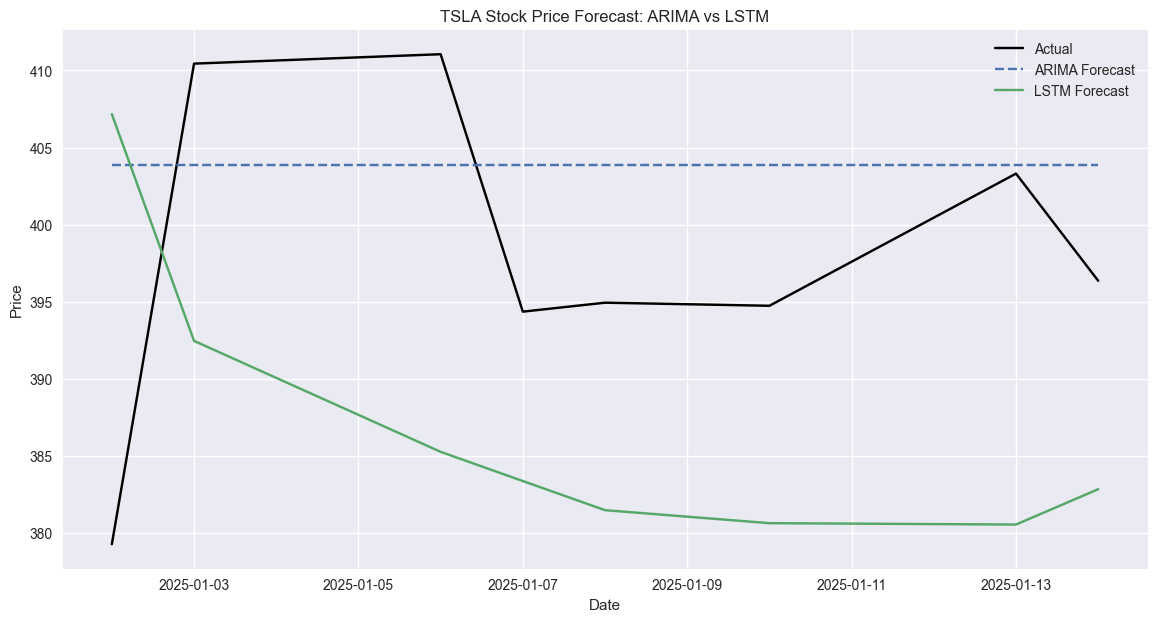

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(test_aligned.index, test_aligned.values, label="Actual", color="black")
plt.plot(test_aligned.index, arima_aligned.values, label="ARIMA Forecast", linestyle="--")
plt.plot(test_aligned.index, lstm_pred, label="LSTM Forecast")
plt.title("TSLA Stock Price Forecast: ARIMA vs LSTM")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# ## 6. Model Selection Discussion
#
# **ARIMA**
# - Interpretable and computationally efficient
# - Performs well on linear, stationary components
# - Struggles with Tesla’s nonlinear volatility
#
# **LSTM**
# - Captures nonlinear patterns and momentum
# - Learns temporal dependencies over 60-day windows
# - Typically achieves lower RMSE and MAPE
#
# **Conclusion:**
# LSTM outperforms ARIMA for Tesla price forecasting due to its ability
# to model complex and volatile market dynamics.